In [2]:
import sys
sys.path.insert(0, '/Users/tbastro/Documents/GitHub/IBIS-Compton-mode-test/')
from comibis.utils import *
from comibis.spec import *
from crab_comibis import *
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import LogFormatter
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
# mpl.rcParams['font.size'] = 'x-large'

# single fit

In [ ]:
src ='crab_polacalib_gran' # 'scox1_spec2_dpe3' # 'crab_spec2_dpe3'# 's1727_spec2' #'m1820_spec2'#  'cygx1_spec2'
scw_file_name_list = ['all'] # ['pre2020', 'post2020'] # ['all'] #  ['dpe3_epimin140_pre2020', 'dpe3_post2020'] # ['dpe3_1500scw']
angle_max = 5. # maximum off-axis angle
spec_sys_error = .1 # systematic error in fraction of flux, typically 1-3%
compnorm = 1 # 'auto'
spicorr = 'auto' # spurious correction factor
spicorr_file = 'compcorrgran350_2YEAR_5deg.csv' #'compcorrpre2020_2YEAR_5deg.csv' # 'spicorr_2YEAR_5deg.csv' # 'spicorr_60REVINT_5deg.csv'# 'spicorr_2YEAR_5deg.csv'
e_min_fit, e_max_fit = 350., 3000. # energy bounds to use for fit
yscale = None #[1e-7, 1e-3]

saved_pola_folder = '/Users/tb272722/Compton/saved_pola_df'
resp_dir = '/Users/tb272722/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'

date_type, start_date, end_date = 'ISOT', None, None 
# date_type, start_date, end_date = 'MJD', None, None #'2012-01-01','2023-01-01' #  None, None 
# date_type, start_date, end_date = 'ISOT', '2014-01-01',  '2025-01-01' #None, None #  #    #
# date_type, start_date, end_date = 'ISOT', '2010-01-01',  '2020-01-01' #None, None #  #    #
rev_list = None #['2680','2681','2682','2683' ,'2684','2685','2686','2688'] #

df_spicorr = pd.read_csv(f'{resp_dir}/{spicorr_file}', index_col=0)
df_pola_scw, all_band_names = charge_df(src, scw_file_name_list, saved_pola_folder, df_spicorr, 0, 1)
df_spicorr_rbn, rbn_compcorr_matrix = rebin_compcorr(df_spicorr, all_band_names)

spec_type = 'EEFLUX' # possible: 'RATE', 'FLUX', 'EFLUX' , 'EEFLUX' , 'ERG'
res_type = 'RES' #'REDCHI2'
rebin_fact_model = 30 #None # factor to re-bin the model spectrum if using RATE
flux_bands= [[200,350],[350,600],[600,1000],[200,1000],[325,480]]
flux_type = 'euf'

comp_response = Response(resp_dir, 'COMP-SEBD-MOD', 'COMP-SRMF-RSP')
# charge df

# df_pola_scw, band_names = charge_df(src, scw_file_name_list, saved_pola_folder, resp_dir, spicorr_file, 0, 1)
df_pola_scw = scw_selection(df_pola_scw, angle_max=angle_max, rev_list=rev_list, start_date=start_date, end_date=end_date, date_type=date_type)
# if spicorr_file: print('mean spicorr = {} mean compnorm = {}'.format(df_pola_scw.spicorr.mean(), df_pola_scw.compnorm.mean()))

comp_spectrum = ComptonSpectrum(df_pola_scw, all_band_names, spec_sys_error, angle_max)
comp_spectrum.make_rate(spicorr=spicorr, compnorm=compnorm, df_spicorr_rbn=df_spicorr_rbn)
comp_response.make_rbn_mat(comp_spectrum.E_bounds_rbn)

print('{0} scw selected = {1} ks exposure'.format(len(df_pola_scw.SCW.unique()), int(comp_spectrum.expo/1000)))
print('Start: {} End: {}'.format(comp_spectrum.ISOT_START,comp_spectrum.ISOT_END))
print('Avg SpiCorr = {:.3f}'.format(df_pola_scw.spicorr.mean()))
print('Avg off-axis angle = {:.3f}'.format(df_pola_scw.ANGLE.mean()))


In [ ]:
# model_name, lmfit_params ='cutoffpl', lm.create_params(K={'value': 18, 'min':0.}, alpha={'value': 1.6, 'min':1.}, beta={'value': 150, 'vary':1} )
# model_name, lmfit_params ='const', lm.create_params(K={'value': 0})
# model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':0}, gamma={'value': gamma_spi, 'min':0.,'vary':0})
# model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':1}, gamma={'value': gamma_spi, 'min':0.,'vary':1})
model_name, lmfit_params ='powerlaw_erg', lm.create_params(K={'value': 1e-9}, gamma={'value': gamma_spi, 'min':1.}, e1={'value': 350, 'vary':0}, e2={'value': 1000, 'vary':0})

model = Model(model_name)

result, minner = fit_spec(comp_spectrum, model, comp_response, lmfit_params, e_min_fit, e_max_fit)
display(result.params)
print(f'Red Chi2 = {result.redchi:.2f}')
# result = fit_spec_alpha(comp_spectrum, model, comp_response, lmfit_params, e_min_fit, e_max_fit)
axes = plot_spec_model(comp_spectrum, model, e_min_fit, e_max_fit, spec_type, 'RES', rebin_fact_model,'log', yscale)
formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
axes[1,0].xaxis.set_minor_formatter(formatter)
axes[1,0].xaxis.set_major_formatter(formatter)
axes[0,0].yaxis.set_minor_formatter(formatter)
axes[0,0].yaxis.set_major_formatter(formatter)
# axes[0,0].set_yscale('linear')
# axes[0,0].grid();axes[1,0].grid()

In [ ]:
# model.calc_flux_model(350.,1000)
# axes[0,0].set_yscale('linear')
# axes[0,0].grid()
axes = plot_spec_model(comp_spectrum, model, e_min_fit, e_max_fit, spec_type, 'RES', rebin_fact_model,'log', yscale)
formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
axes[1,0].xaxis.set_minor_formatter(formatter)
axes[1,0].xaxis.set_major_formatter(formatter)
axes[0,0].yaxis.set_minor_formatter(formatter)
axes[0,0].yaxis.set_major_formatter(formatter)
plt.savefig(f'/Users/tb272722/Manuscript/crab_all_350_3000kev_beta.pdf', bbox_inches='tight')
# plt.savefig(f'/Users/tb272722/Manuscript/crab_all_fitCHE_showCLE.pdf')

# Raw spectrum (comp and spurious)

2268 scw found
['150-200' '200-210' '210-220' '220-230' '230-240' '240-250' '250-260'
 '260-270' '270-280' '280-290' '290-300' '300-350' '350-400' '400-450'
 '450-500' '500-600' '600-700' '700-800' '800-1000' '1000-1500'
 '1500-2000' '2000-2500' '2500-3000']
unique sel: 22
nb of selected obs: 8
selection:  [[np.int64(2003), np.int64(2004), np.int64(2005)], [np.int64(2006), np.int64(2007), np.int64(2008)], [np.int64(2009), np.int64(2010), np.int64(2011)], [np.int64(2012), np.int64(2013), np.int64(2014)], [np.int64(2015), np.int64(2016), np.int64(2017)], [np.int64(2018), np.int64(2019), np.int64(2020)], [np.int64(2021), np.int64(2022), np.int64(2023)], [np.int64(2024)]]
average spicorr = 0.635
******************************************************************************************

Start: 2012-04-10 09:37:54.826000 End: 2014-10-21 23:31:58.915000


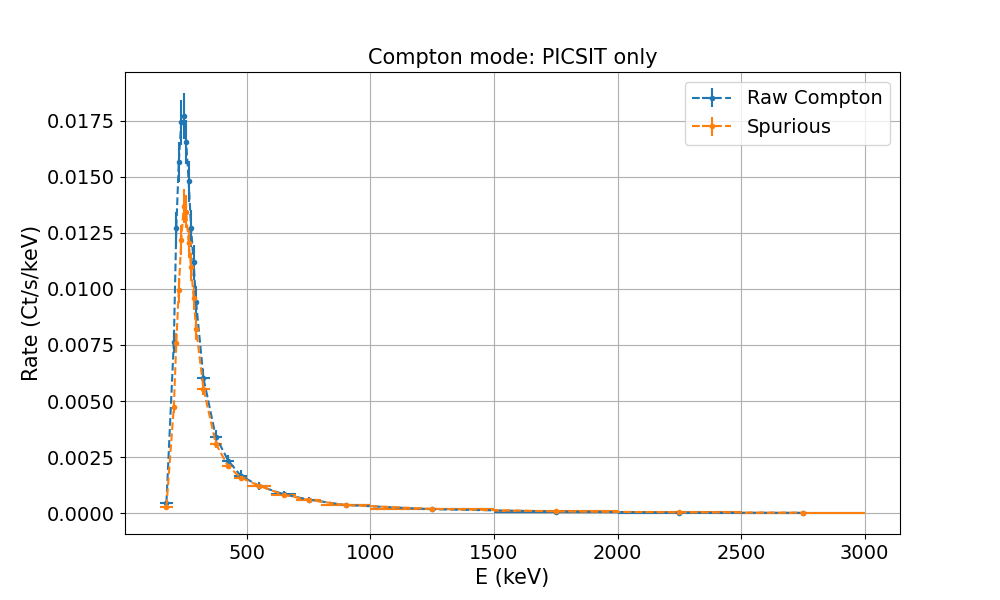

In [ ]:
def plot_raw_spec(df_pola_scw_sel, ratio=True):
    print('******************************************************************************************\n')
    comp_spectrum = ComptonSpectrum(df_pola_scw_sel, all_band_names, spec_sys_error, angle_max)
    comp_spectrum.make_rate(spicorr=0, compnorm=1)

    spur_spectrum = ComptonSpectrum(df_pola_scw_sel, all_band_names, spec_sys_error, angle_max)
    if ratio: spur_spectrum.make_rate(spicorr='auto', compnorm=0) # this will be = - beta*S
    else: spur_spectrum.make_rate(spicorr=-1, compnorm=0) # this will be = - beta*S

    print('Start: {} End: {}'.format(comp_spectrum.ISOT_START, comp_spectrum.ISOT_END))
    compnorm_spec = -spur_spectrum.rate/comp_spectrum.rate
    compnorm_spec_err = np.abs(compnorm_spec) * np.sqrt((comp_spectrum.rate_err/comp_spectrum.rate)**2 + (spur_spectrum.rate_err/spur_spectrum.rate)**2)
    fig, ax= plt.subplots(1,1,figsize=(10,6))
    if ratio:
        ax.errorbar(x=spur_spectrum.E, xerr=spur_spectrum.dE/2, y = compnorm_spec, yerr= compnorm_spec_err, fmt='.', label='Spurious')
        ax.axhline(y=1., color='grey',linestyle='--')
        ax.set_ylabel('(beta*S)/C')
        ax.set_ylim(top=4, bottom=-1.)
        ax.set_xlim( left=200, right=400)
    else:
        ax.errorbar(x=comp_spectrum.E, xerr=comp_spectrum.dE/2, y = comp_spectrum.rate, yerr=comp_spectrum.rate_err, fmt='.--', label= 'Raw Compton')
        ax.errorbar(x=spur_spectrum.E, xerr=spur_spectrum.dE/2, y = spur_spectrum.rate, yerr=spur_spectrum.rate_err, fmt='.--', label='Spurious')
        ax.set_ylabel('Rate (Ct/s/keV)')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('E (keV)')
    return compnorm_spec, compnorm_spec_err, ax

column_name='YEAR'
k=3
ratio=0

# %matplotlib widget
src = 'crab_polacalib_gran' # 'scox1_vlowefine_dpe3'# 's1727_spec2' #'m1820_spec2'#  'cygx1_spec2'
scw_file_name_list = ['p1'] # ['dpe3_epimin140_pre2020', 'dpe3_post2020'] # ['dpe3_1500scw']
angle_max = 5 # maximum off-axis angle
spec_sys_error = .05 # systematic error in fraction of flux, typically 1-3%
spicorr_file = 'spicorrdpe_2YEAR_5deg.csv' # 'spicorr_2YEAR_5deg.csv' # 'spicorr_60REVINT_5deg.csv'# 'spicorr_2YEAR_5deg.csv'
yscale = None #[1e-7, 1e-3]

saved_pola_folder = '/Users/tb272722/Compton/saved_pola_df'
resp_dir = '/Users/tb272722/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'

df_spicorr = pd.read_csv(f'{resp_dir}/{spicorr_file}', index_col=0)
df_pola_scw, all_band_names = charge_df(src, scw_file_name_list, 'saved_pola_df', df_spicorr, 0)
# df_pola_scw, band_names = charge_df(src, scw_file_name_list, saved_pola_folder, resp_dir, spicorr_file, None, 0)
# all_unique=np.sort(df_pola_scw[column_name].unique())[:]
all_unique= np.arange(2003,2025)

select_list=[list(all_unique)[i*k:(i+1)*k] for i in range(len(all_unique)//k+(len(all_unique)%k!=0))]
print(f'unique sel: {len(all_unique)}')
print(f'nb of selected obs: {len(select_list)}')
print('selection: ',select_list)
%matplotlib widget

for i, sel in enumerate(select_list[3:4]):
    df_pola_scw_sel=df_pola_scw[df_pola_scw.YEAR<2008]
    # df_pola_scw_sel=df_pola_scw[df_pola_scw[column_name].isin(sel)]
    print('average spicorr = {:.3f}'.format(df_pola_scw_sel.spicorr.mean()))
    # compnorm_spec, compnorm_spec_err, ax = plot_raw_spec(df_pola_scw_sel, ratio=False)
    compnorm_spec, compnorm_spec_err, ax = plot_raw_spec(df_pola_scw_sel, ratio=ratio)
    # ax.set_xlim(170, 400)
    ax.set_title('Compton mode: PICSIT only')
    plt.show()
    # plt.savefig(f'/Users/tb272722/Manuscript/raw_counts_crab_{i}.pdf')


# many fit

In [ ]:
# %matplotlib inline
src = 'crab_polacalib_gran'# 'm1820_spec2' # 'cygx1_spec2_auto'
scw_file_name_list =['all'] # ['pre2020', 'post2020']# ['auto_newic_all'] # newic_eismin40_past2020
angle_max = 5. # maximum off-axis angle
spec_sys_error = .0 # systematic error in fraction of flux, typically 1-3%
spicorr = 'auto' # spurious correction factor
compnorm= 1

saved_pola_folder='/Users/tb272722/Compton/saved_pola_df'
resp_dir = '/Users/tb272722/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'
spicorr_file ='compcorrgran350_2YEAR_5deg.csv' # 'spicorr_2YEAR_5deg.csv' #'spicorr_60REVINT_5deg.csv' #  'spicorr_2YEAR_5deg.csv'

e_min_fit, e_max_fit = 350., 1500. # energy bounds to use for fit
flux_type='eeuf'
k = 2
column_name = 'YEAR'
states_dico = None #S1727_groups

flux_bands= [[350,1000]]
plot_fit=1
spec_type='FLUX' # possible: 'RATE', 'FLUX', 'EFLUX' , 'EEFLUX' , 'ERG'
res_type= None #'REDCHI2' #'RES'
rebin_fact_model = 30 #None # factor to re-bin the model spectrum if using RATE
yscale= None # [1e-3, 2e-2]

model_name, lmfit_params ='powerlaw_erg', lm.create_params(K={'value': 1e-9}, gamma={'value': gamma_spi, 'min':1.}, e1={'value': 350, 'vary':0}, e2={'value': 1000, 'vary':0})
# model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':1}, gamma={'value': gamma_spi, 'min':0.,'vary':1})
# model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':0}, gamma={'value': gamma_spi, 'min':0.,'vary':0}, spicorr={'value':.9, 'min':0})
# model_name, lmfit_params ='bknpower', lm.create_params(K={'value': 18}, gamma1={'value': 4, 'min':0.,'vary':1} ,\
#                                                        Eb={'value':350,'min':250,'max':500, 'vary':1}, gamma2={'value':gamma_spi,'vary':1})

model = Model(model_name)
comp_response = Response(resp_dir, 'COMP-SEBD-MOD', 'COMP-SRMF-RSP')

df_spicorr = pd.read_csv(f'{resp_dir}/{spicorr_file}', index_col=0)
df_pola_scw, all_band_names = charge_df(src, scw_file_name_list, saved_pola_folder, df_spicorr, 0, 1)
df_spicorr_rbn, rbn_compcorr_matrix = rebin_compcorr(df_spicorr, all_band_names)
df_pola_scw = scw_selection(df_pola_scw, angle_max=angle_max)

all_unique=np.sort(df_pola_scw[column_name].unique())[:]
select_list=[list(all_unique)[i*k:(i+1)*k] for i in range(len(all_unique)//k+(len(all_unique)%k!=0))][:]
if states_dico == None: select_list, select_names= [list(all_unique)[i*k:(i+1)*k] for i in range(len(all_unique)//k+(len(all_unique)%k>0))], None
else: select_list, select_names= list(states_dico.values()), list(states_dico.keys())

result_list, flux_list, select_name_list = [], [], []

for i, sel in enumerate(select_list[:]):
    if states_dico: sel_name = select_names[i]
    else: sel_name = '{}-{}'.format(sel[0],sel[-1])
    df_pola_scw_sel=df_pola_scw[df_pola_scw[column_name].isin(sel)]
    
    print('******************************************************************************************\n')
    comp_spectrum = ComptonSpectrum(df_pola_scw_sel, all_band_names, spec_sys_error, angle_max)
    comp_spectrum.make_rate(spicorr=spicorr)
    print('{} {} (expo = {:.1f} Ms)'.format(column_name, sel_name, df_pola_scw_sel.EXPO.sum()/1e6))
    print('Start: {} End: {}'.format(comp_spectrum.ISOT_START, comp_spectrum.ISOT_END))
    print('average spicorr = {:.3f}'.format(df_pola_scw_sel.spicorr.mean()))

    comp_response.make_rbn_mat(comp_spectrum.E_bounds_rbn)
    result, minner = fit_spec(comp_spectrum, model, comp_response, lmfit_params, e_min_fit, e_max_fit)
    display(result)
    model.calc_flux_model(350, 1000,verbose=1)
    if plot_fit:
        plot_spec_model(comp_spectrum, model, e_min_fit, e_max_fit, spec_type=spec_type, res_type=res_type, \
                        rebin_fact_model=False, rbn_type='log', yscale=yscale)
    plt.show()
    select_name_list.append(sel_name) # result.params['gamma'].stderr
    flux_list.append([model.calc_flux_model(ebd[0], ebd[1], flux_type=flux_type, N_flux_bin=100, verbose=0) for ebd in flux_bands])

    par_model_list=[]
    for par in result.params.keys():
        par_model_list+=[result.params[par].value, result.params[par].stderr]
    result_list.append([sel[0],sel[-1],comp_spectrum.ISOT_START, comp_spectrum.ISOT_END, comp_spectrum.expo, result.redchi]+par_model_list)

par_column_names = []
for par_name in lmfit_params.keys():
    par_column_names+=[par_name, par_name+'_err']
df_param_fit = pd.DataFrame(result_list, columns=[column_name+'_START',column_name+'_END','ISOT_START','ISOT_END','EXPO','REDCHI2']+par_column_names, index=select_name_list) # 
df_flux_fit = pd.DataFrame(flux_list, columns=['{}-{}'.format(ebd[0],ebd[1]) for ebd in flux_bands], index=select_name_list) # 
df_result_fit = pd.merge(df_param_fit,df_flux_fit,right_index=True, left_index=True)
df_result_fit['ISOT_ERR'] = (df_result_fit['ISOT_END'] - df_result_fit['ISOT_START']) / 2
df_result_fit['ISOT'] = df_result_fit['ISOT_START'] + df_result_fit['ISOT_ERR']
df_result_fit

In [ ]:
param_name = 'gamma'
save_dir= '/Users/tb272722/Compton/papier_compton'

i_start, i_stop=0,None
fr_band=.15
print(f'Average redChi2 = {df_result_fit.REDCHI2.mean()}')
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].errorbar(x='ISOT', xerr='ISOT_ERR', y=param_name,yerr=param_name+'_err',\
                fmt='k.',data=df_result_fit.iloc[i_start:i_stop], label='IBIS Compton')
ax[0].set_ylabel(r'Photon Index ($\Gamma$)')
ax[1].errorbar(x='ISOT',xerr='ISOT_ERR', y='K',yerr='K_err', fmt='k+', label='IBIS Compton', data=df_result_fit.iloc[i_start:i_stop])

if 'crab' in src:
    # compute flux with SPI parameters
    model_spi = Model('powerlaw')
    model_spi.model_parameters = lm.create_params(K={'value': K_spi}, gamma={'value': gamma_spi})
    spi_crab_flux = model_spi.calc_flux_model(350, 1000, verbose=0)
    if param_name=='gamma':ax[0].axhline(gamma_spi, color='red', linestyle='--', label='SPI')
    ax[1].axhline(spi_crab_flux, color='red', linestyle='--', label='SPI')

    y_lim_flux = (ax[1].get_ylim()/spi_crab_flux - 1)*100
    ax[1].set_ylim(top=spi_crab_flux*(1. + fr_band), bottom=spi_crab_flux*(1. - fr_band))

    ax2= ax[1].twinx()
    ax2.axhline(0,color='red', linestyle='--', label='SPI')
    # ax2.plot(df_result_fit.iloc[i_start:i_stop]['ISOT'], 'k+')
    # ax[1].errorbar(x='ISOT',xerr='ISOT_ERR', y= (df_result_fit.iloc[i_start:i_stop]['K']/spi_crab_flux-1)*100,
    #                yerr= (df_result_fit.iloc[i_start:i_stop]['K_err']/spi_crab_flux-1)*100, fmt='k+', alpha=0., label='IBIS Compton')
    ax2.set_ylim(top=fr_band*100, bottom=-fr_band*100)
    
    # ax2.set_ylim(top=y_lim_flux[1], bottom=y_lim_flux[0])
    ax2.set_ylabel('Deviation from SPI (%)')

ax[1].set_ylabel(r'Flux (erg cm$^{-2}$ s$^{-1}$)')
#ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('YEAR')
plt.savefig(f'{save_dir}/crab_gamma_flux_{k}{column_name}.pdf')

In [ ]:
def print_param_spec_latex(df):
    df['Y_range'] = df.apply(lambda x:f'{x.YEAR_START} -- {x.YEAR_END}', axis=1)
    df['K_tex'] = df.apply(lambda x:f'{x.K*1e9:.2f} $\pm$ {x.K_err*1e9:.2f}', axis=1)
    df['gamma_tex'] = df.apply(lambda x:f'{x.gamma:.2f} $\pm$ {x.gamma_err:.2f}', axis=1)
    df['expo_Ms'] =  df.apply(lambda x:f'{x.EXPO/1e6:.2f}', axis=1)

    # formatters_dict.update({col: '{:.0f}'.format for col in ['SNR','EXPO_ks']})
    print(df[['Y_range', 'K_tex', 'gamma_tex', 'expo_Ms']].to_latex(index=False, header=['Date', 'Flux', '$\Gamma$', 'Expo (Ms)']))
    #[['PA'	PA_err	PF	PF_err	uplim	SNR	redchi2	p_higher	sigma_higher	ISOT_MID	ISOT_ERR	MJD_MID	MJD_ERR	EXPO	PF_pct	PF_pct_err	uplim_pct	EXPO_ks]]
    return df

print_param_spec_latex(df_result_fit)

# SpiCorr fit

In [ ]:
%matplotlib inline
src = 'crab_polacalib_gran' # 'crab_spec2_dpe3' # 'cygx1_spec2_auto'
scw_file_name_list = ['p1','p2','p3']# ['pre2020','post2020'] # ['1500scw']#
angle_max = 5. # maximum off-axis angle
spec_sys_error = .05 # systematic error in fraction of flux, typically 1-3%
# spicorr = 'auto' # spurious correction factor
compnorm = 1
spicorr_file=None
e_min_fit, e_max_fit = 350., 1500. # energy bounds to use for fit
k = 2
column_name = 'YEAR'
moving_window = False
only_unique = True
flux_type='eeuf'
flux_bands = [[350,1500]]

save_dir= '/Users/tb272722/Compton/papier_compton'
plot_compcorr=0
plot_fit = 0
yscale =None #[1e-3, 3e-2]
spec_type = 'FLUX' # possible: 'RATE', 'FLUX', 'EFLUX' , 'EEFLUX' , 'ERG'
res_type=None #'RES'# None
rebin_fact_model = 30 #None # factor to re-bin the model spectrum if using RATE
gamma_spi, K_spi = 2.24, 18.2 # 2.27, 21.4 # fit from 100 keV - 1 MeV of spectrum_535_1019_photo_Crab_Nebula_00001.fits

# model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':0}, gamma={'value': gamma_spi, 'min':0.,'vary':0}, spicorr={'value':.9, 'min':0})
model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':0}, gamma={'value': gamma_spi,'vary':0}, \
                           spicorr={'value':1., 'vary':1}, compnorm={'value':1., 'min':0., 'vary':0})
# model_name, lmfit_params ='grbm', lm.create_params(K={'value': 7.52e-4, 'vary':0}, alpha1={'value': -1.99,'vary':0}, alpha2={'value': -2.32,'vary':0}, Ec={'value': 531,'vary':0}, \
#                                                   spicorr={'value':1., 'min':0., 'max':2.}, compnorm={'value':1., 'min':0., 'max':2., 'vary':1})

model = Model(model_name) # initialize model
resp_dir = '/Users/tb272722/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'
comp_response = Response(resp_dir, 'COMP-SEBD-MOD', 'COMP-SRMF-RSP')

df_pola_scw, band_names = charge_df(src, scw_file_name_list, '/Users/tb272722/Compton/saved_pola_df', None, None, 0)
df_pola_scw = scw_selection(df_pola_scw, angle_max)
# df_pola_scw = select_by_scw(df_pola_scw, '/Users/tb272722/CygnusX1/scw_cyg_x-1_Floriane', ['liste_hard.lst'])

if only_unique: all_unique=np.sort(df_pola_scw[column_name].unique())[:]
else: all_unique=np.arange(df_pola_scw[column_name].min(), df_pola_scw[column_name].max()+1)

if moving_window: select_list = [list(all_unique)[i:i+k] for i in range(len(all_unique)-k+1)]
else: select_list = [list(all_unique)[i*k:(i+1)*k] for i in range(len(all_unique)//k+(len(all_unique)%k>0))]

print(f'selected {column_name}: {select_list}')
result_list, flux_list, select_name_list = [], [], []
comp_corr_list, comp_corr_err_list= [], []

for sel in select_list[:]:
    sel_name = '{}-{}'.format(sel[0],sel[-1])
    df_pola_scw_sel=df_pola_scw[df_pola_scw[column_name].isin(sel)]
    
    print('******************************************************************************************\n')
    print('{} {} (expo = {:.1f} Ms)'.format(column_name, sel_name, df_pola_scw_sel.EXPO.sum()/1e6))
    avg_offaxis=df_pola_scw_sel.ANGLE.mean()
    print('Avg off-axis angle = {:.3f}'.format(avg_offaxis))
    try:
        comp_spectrum = ComptonSpectrum(df_pola_scw_sel, band_names, spec_sys_error, angle_max)
        # comp_spectrum.make_rate(spicorr, compnorm)
        comp_response.make_rbn_mat(comp_spectrum.E_bounds_rbn)
        result, minner = fit_spec_alpha(comp_spectrum, model, comp_response, lmfit_params, e_min_fit, e_max_fit)
        display(result.params)
        print('Red chi2 = {}'.format(result.redchi))

        # find the energy-dependant correction on raw Compton rate (with no fit!)
        # mostly important for E<300 keV: C = alpha(t,E) * comp - beta(t) * spurious
        diff = comp_spectrum.rate - model.model_spec_rbn # corrected Compton - model
        ### beta first, alpha second
        comp_spectrum.make_rate(spicorr = 0, compnorm = 1) # raw Compton rate
        comp_raw = comp_spectrum.rate # raw compton rate
        comp_raw_err = comp_spectrum.rate_err # raw compton error
        comp_corr = 1 - diff/comp_raw # alpha

        comp_spectrum.make_rate(spicorr = -result.params['spicorr'].value, compnorm = 0) # only spurious
        spur_raw_err = comp_spectrum.rate_err
        comp_corr_err = np.sqrt(comp_corr**2 * (comp_raw_err/comp_raw)**2 + (spur_raw_err/comp_raw)**2)
        print('alpha error (%) = ',comp_corr_err/comp_corr,'mean = ', (comp_corr_err/comp_corr).mean())

        ### only beta
        # comp_spectrum.make_rate(spicorr = 1, compnorm = 0) # raw spurious rate
        # comp_corr = 1 - diff/comp_spectrum.rate

        comp_corr_list.append(comp_corr)
        comp_corr_err_list.append(comp_corr_err)

        if plot_fit:
            axes = plot_spec_model(comp_spectrum, model, e_min_fit, e_max_fit, spec_type=spec_type, res_type=res_type, \
                            rebin_fact_model=False, rbn_type='log', yscale=yscale)
            axes[0,0].legend(['Fixed SPI spectrum', 'Compton spectrum'])
            # if save_dir is not None:
            #     plt.savefig(f'{save_dir}/crab_beta_fit_2013_2015.pdf')
            plt.show()

        if plot_compcorr:
            fig, ax=plt.subplots(1,1, figsize=(10,6))
            ax.errorbar(x=comp_spectrum.E, xerr=comp_spectrum.dE/2, y=comp_corr, yerr=comp_corr_err, color='blue', linestyle='--') # , label='raw Compton correction'
            ax.set_xscale('log')
            formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
            ax.xaxis.set_minor_formatter(formatter)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('E (keV)')
            ax.set_ylabel(r'$\alpha$ raw Compton correction')
            ax.grid(True, which='both')
            # plt.savefig(f'/Users/tb272722/Manuscript/alpha_raw_correction_2013_2015.pdf')
            plt.show()

        select_name_list.append(sel_name) # result.params['gamma'].stderr
        flux_list.append([sel[0],sel[-1]]+[model.calc_flux_model(ebd[0], ebd[1], flux_type=flux_type, N_flux_bin=100) for ebd in flux_bands])

        par_model_list=[]
        for par in result.params.keys():
            par_model_list+=[result.params[par].value, result.params[par].stderr]
        result_list.append([sel[0],sel[-1],result.redchi,avg_offaxis]+par_model_list)
    except Exception as e:
        print(f'Error {e} occured')
        pass


In [ ]:
par_column_names = []
for par_name in lmfit_params.keys():
    par_column_names+=[par_name, par_name+'_err']
df_param_fit = pd.DataFrame(result_list, columns=[column_name+'_START',column_name+'_END','REDCHI2','OFFAXIS']+par_column_names, index=select_name_list) # 
df_flux_fit = pd.DataFrame(flux_list, columns=[column_name+'_START',column_name+'_END']+['{}-{}'.format(ebd[0],ebd[1]) for ebd in flux_bands], index=select_name_list) # 

# add energy+time dependant compnorm to df
for i in range(len(comp_spectrum.E_bounds_rbn)):
    e_range=comp_spectrum.E_bounds_rbn[i]
    df_param_fit['compcorr_{}_{}'.format(e_range[0],e_range[1])]  = np.array(comp_corr_list).T[i]
    df_param_fit['compcorr_err_{}_{}'.format(e_range[0],e_range[1])]  = np.array(comp_corr_err_list).T[i]
    
df_param_fit[column_name+'_ERR'] = (df_param_fit[column_name+'_END'] - df_param_fit[column_name+'_START'] + 1)/2
df_param_fit[column_name+'_AVG'] = df_param_fit[column_name+'_START'] + df_param_fit[column_name+'_ERR']
df_param_fit

In [9]:
column_name = 'YEAR'
param_save_dir='/Users/tbastro/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'
df_param_fit = pd.read_csv(f'{param_save_dir}/compcorrgran350_2YEAR_5deg.csv', index_col=0)

NameError: name 'comp_spectrum' is not defined

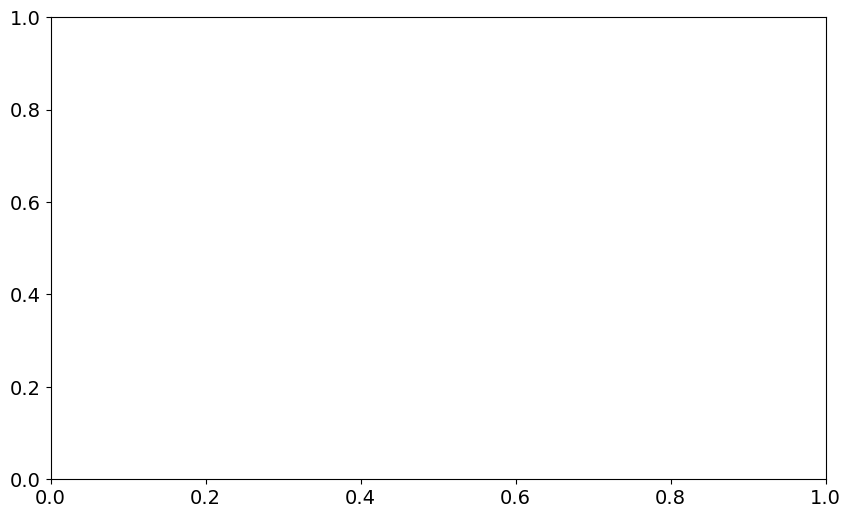

In [6]:
save_dir='/Users/tb272722/Compton/papier_compton'
fig, ax= plt.subplots(1,1,figsize=(10,6))
for i in range(1,13,3):
    e_range=comp_spectrum.E_bounds_rbn[i]
    ax.errorbar(x=column_name+'_AVG', xerr=column_name+'_ERR',  y= 'compcorr_{}_{}'.format(e_range[0],e_range[1]), yerr= 'compcorr_err_{}_{}'.format(e_range[0],e_range[1]),
                fmt='--', data=df_param_fit, label=f'{e_range[0]}-{e_range[1]}')
ax.set_ylabel(r'$\alpha$ raw Compton correction')
ax.set_xlabel('YEAR')
ax.grid()
ax.legend()
# plt.savefig(f'{save_dir}/alpha_evolution_every{k}{column_name}.pdf')

NameError: name 'comp_spectrum' is not defined

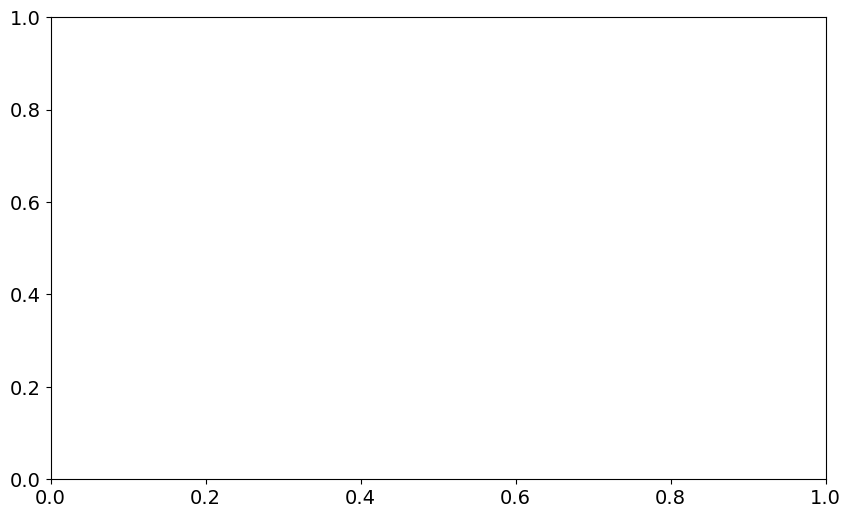

In [7]:
save_dir='/Users/tb272722/Compton/papier_compton'
emaxidx=3
fig, ax=plt.subplots(1,1, figsize=(10,6))
ax.errorbar(x=comp_spectrum.E[1:-emaxidx], xerr=comp_spectrum.dE[1:-emaxidx]/2, y=comp_corr[1:-emaxidx], yerr=comp_corr_err[1:-emaxidx], color='blue', linestyle='--') # , label='raw Compton correction'
ax.axhline(1, linestyle='--', color='grey', alpha=.7)
ax.set_xscale('log')
formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
ax.xaxis.set_minor_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('E (keV)')
ax.set_ylabel(r'$\alpha$ raw Compton correction')
# ax.grid(True, which='both')
plt.savefig(f'{save_dir}/alpha_raw_correction_2013_2015.pdf')
# plt.show()

Text(0.5, 0, 'YEAR')

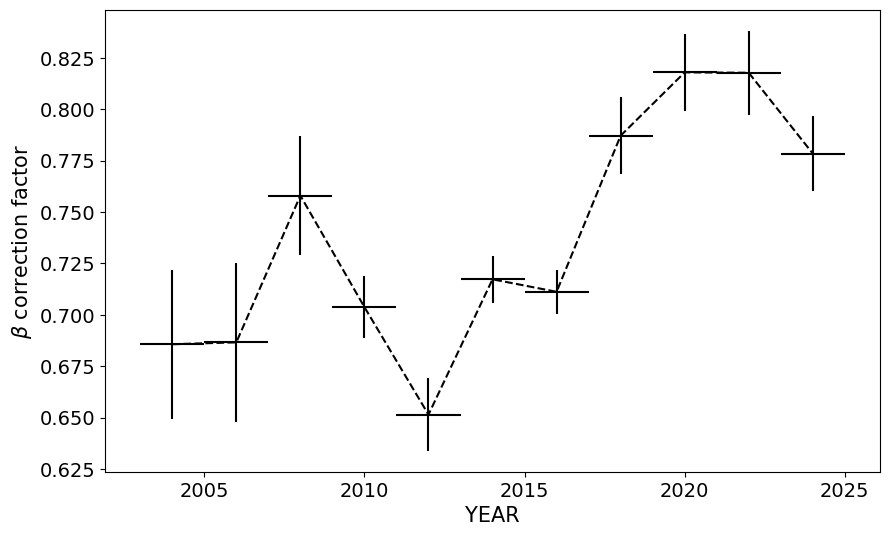

In [ ]:
i_start=0
save_dir='/Users/tb272722/Compton/papier_compton'

fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.errorbar(x=column_name+'_AVG', xerr=column_name+'_ERR',yerr='spicorr_err', y='spicorr',fmt='k--',data=df_param_fit.iloc[i_start:], label='SpiCorr' )#
# ax.errorbar(x=column_name+'_AVG', xerr=column_name+'_ERR',y='compnorm',fmt='--',data=df_param_fit.iloc[i_start:], label='CompNorm')#,yerr='compnorm_err'
ax.set_ylabel(r'$\beta$ correction factor')

# ax2=ax.twinx()
# ax2.errorbar(x='YEAR_AVG', xerr='YEAR_ERR', y='OFFAXIS',fmt='k--',alpha=.6,data=df_param_fit.iloc[i_start:], label='Off-axis angle')#,yerr='compnorm_err'
# ax2.set_ylabel('Off-axis angle (°)')

# ax.plot(df_param_fit['YEAR_AVG'],df_param_fit.spicorr/df_param_fit.compnorm,label='spicorr/compnorm')
# ax.axhline(1.,color='k')
ax.set_xlabel(column_name)
# ax.set_ylim(bottom=0.55, top=0.8)
# ax.grid()
# ax.set_title('SpiCorr evolution from Crab fit (every {} {})'.format(k, column_name))
# ax.legend();ax.grid()
# plt.savefig(f'{save_dir}/beta_evolution_every{k}{column_name}_gran.pdf')

## save calib params

In [ ]:
param_save_dir='/Users/tbastro/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'
# param_save_file = '{}/spicorr_{}{}_300_1500keV.csv'.format(param_save_dir,k,column_name,int(angle_max))
param_save_file = f'{param_save_dir}/compcorrgran350_{k}{column_name}_{int(angle_max)}deg.csv'
df_param_fit.to_csv(param_save_file)#.spicorr.mean()
print('{} saved!'.format(param_save_file))
# df_param_fit.to_csv('spicorr_{}{}_{}deg.csv'.format(k,column_name,int(angle_max)))#.spicorr.mean()

import calib file

# beta only

In [ ]:
%matplotlib inline
src = 'crab_polacalib' # 'crab_spec2_dpe3' # 'cygx1_spec2_auto'
scw_file_name_list = ['all']# ['pre2020','post2020'] # ['1500scw']#
angle_max = 5. # maximum off-axis angle
spec_sys_error = .05 # systematic error in fraction of flux, typically 1-3%
# spicorr = 'auto' # spurious correction factor
compnorm = 1
spicorr_file=None
e_min_fit, e_max_fit = 200., 1500. # energy bounds to use for fit
k = 4
column_name = 'YEAR'
moving_window = False
only_unique = True
flux_type='eeuf'
flux_bands = [[350,1500]]

save_dir= None #'/Users/tb272722/Manuscript'
plot_compcorr=1
plot_fit = 1
yscale =None #[1e-3, 3e-2]
spec_type = 'FLUX' # possible: 'RATE', 'FLUX', 'EFLUX' , 'EEFLUX' , 'ERG'
res_type=None #'RES'# None
rebin_fact_model = 30 #None # factor to re-bin the model spectrum if using RATE
gamma_spi, K_spi = 2.24, 18.2 # 2.27, 21.4 # fit from 100 keV - 1 MeV of spectrum_535_1019_photo_Crab_Nebula_00001.fits
# model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':0}, gamma={'value': gamma_spi, 'min':0.,'vary':0}, spicorr={'value':.9, 'min':0})
model_name, lmfit_params ='powerlaw', lm.create_params(K={'value': K_spi, 'vary':0}, gamma={'value': gamma_spi,'vary':0}, \
                           spicorr={'value':1., 'vary':1}, compnorm={'value':1., 'min':0., 'vary':0})

model = Model(model_name) # initialize model
resp_dir = '/Users/tb272722/Documents/GitHub/IBIS-Compton-mode-test/compton_responses'
comp_response = Response(resp_dir, 'COMP-SEBD-MOD', 'COMP-SRMF-RSP')

df_pola_scw, band_names = charge_df(src, scw_file_name_list, '/Users/tb272722/Compton/saved_pola_df', None, None, 0)
df_pola_scw = scw_selection(df_pola_scw, angle_max)
# df_pola_scw = select_by_scw(df_pola_scw, '/Users/tb272722/CygnusX1/scw_cyg_x-1_Floriane', ['liste_hard.lst'])

if only_unique: all_unique=np.sort(df_pola_scw[column_name].unique())[:]
else: all_unique=np.arange(df_pola_scw[column_name].min(), df_pola_scw[column_name].max()+1)

if moving_window: select_list = [list(all_unique)[i:i+k] for i in range(len(all_unique)-k+1)]
else: select_list = [list(all_unique)[i*k:(i+1)*k] for i in range(len(all_unique)//k+(len(all_unique)%k>0))]

print(f'selected {column_name}: {select_list}')
result_list, flux_list, select_name_list = [], [], []
comp_corr_list= []

for sel in select_list[3:4]:
    sel_name = '{}-{}'.format(sel[0],sel[-1])
    df_pola_scw_sel=df_pola_scw[df_pola_scw[column_name].isin(sel)]
    
    print('******************************************************************************************\n')
    print('{} {} (expo = {:.1f} Ms)'.format(column_name, sel_name, df_pola_scw_sel.EXPO.sum()/1e6))
    avg_offaxis=df_pola_scw_sel.ANGLE.mean()
    print('Avg off-axis angle = {:.3f}'.format(avg_offaxis))
    try:
        comp_spectrum = ComptonSpectrum(df_pola_scw_sel, band_names, spec_sys_error, angle_max)
        comp_response.make_rbn_mat(comp_spectrum.E_bounds_rbn)
        
        # result, minner = fit_spec_alpha(comp_spectrum, model, comp_response, lmfit_params, e_min_fit, e_max_fit)
        
        # find the energy-dependant correction on spurious (with no fit!)
        print('make raw compton rate')
        comp_spectrum.make_rate(spicorr = 0, compnorm = 1) # raw Compton rate
        raw_rate = comp_spectrum.rate
        raw_err = comp_spectrum.rate_err
        print('find model rate')
        comp_spectrum.make_fit_ebd(e_min_fit, e_max_fit) 
        model.residual_compton(lmfit_params, comp_spectrum, comp_response) # to compute the model count-rates
        print('make spurious rate')
        comp_spectrum.make_rate(spicorr = -1, compnorm = 0) # raw Compton rate
        spur_rate = comp_spectrum.rate # spurious rate
        spur_err = comp_spectrum.rate_err
        print('find spurious correction factor')
        spur_corr = (raw_rate - model.model_spec_rbn)/spur_rate
        print(spur_corr)
        # comp_corr_err = np.sqrt(comp_corr**2 * (comp_raw_err/comp_raw)**2 + (spur_raw_err/comp_raw)**2)
        # print('alpha error (%) = ',comp_corr_err/comp_corr,'mean = ', (comp_corr_err/comp_corr).mean())

        if plot_compcorr:
            fig, ax=plt.subplots(1,1, figsize=(10,6))
            ax.errorbar(x=comp_spectrum.E[1:], xerr=comp_spectrum.dE[1:]/2, y=spur_corr[1:], yerr=0, color='blue', linestyle='--') # , label='raw Compton correction'
            ax.set_xscale('log')
            formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
            ax.xaxis.set_minor_formatter(formatter)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('E (keV)')
            ax.set_ylabel(r'$\beta$ correction')
            ax.grid(True, which='both')
            plt.show()

        select_name_list.append(sel_name) # result.params['gamma'].stderr
        flux_list.append([sel[0],sel[-1]]+[model.calc_flux_model(ebd[0], ebd[1], flux_type=flux_type, N_flux_bin=100) for ebd in flux_bands])

        par_model_list=[]
        for par in result.params.keys():
            par_model_list+=[result.params[par].value, result.params[par].stderr]
        result_list.append([sel[0],sel[-1],result.redchi,avg_offaxis]+par_model_list)
    except Exception as e:
        print(f'Error {e} occured')
        pass


# Plot responses

In [ ]:
I_min, I_max, J_min, J_max = comp_response.I[0], comp_response.I[-1], comp_response.J[0], comp_response.J[-1]
fig, ax= plt.subplots(1,1,figsize=(10,8))
cb=ax.imshow(comp_response.rmf_mat['MATRIX'], extent=[I_min, I_max, J_min, J_max ],
             origin='lower', aspect= (I_min - I_max)/(J_min - J_max),   vmax=4e-3, cmap='magma')
ax.set_xlabel('Reconstructed Energy (keV)')
ax.set_ylabel('True Energy (keV)')
plt.colorbar(cb)
plt.savefig(f'/Users/tb272722/Manuscript/compton_rmf.pdf')

In [ ]:
ax=comp_response.plot_arf()
# ax.set_xlim(10)
ax.set_xscale('log')
formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
ax.xaxis.set_minor_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('E (keV)')
plt.savefig(f'/Users/tb272722/Manuscript/compton_arf.pdf')